# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

## Импорт библиотек

In [1]:
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path

import time

import torch
import torchvision

import PIL
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
use_gpu = torch.cuda.is_available()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA is available!  Training on GPU ...


Делаем код воспроизводимым.


In [2]:
seed = 42
np.random.seed(seed)

  ## Подготовка исходных данных

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
# зададим колличество батчей
batch_size = 4

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Функция для отрисовки

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Загрузка исходных данных

In [6]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_labels = [i.parent.name for i in test_files]

Разбиваем данные на трейн и валидацию.

In [7]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

 Посмотрим на данные.

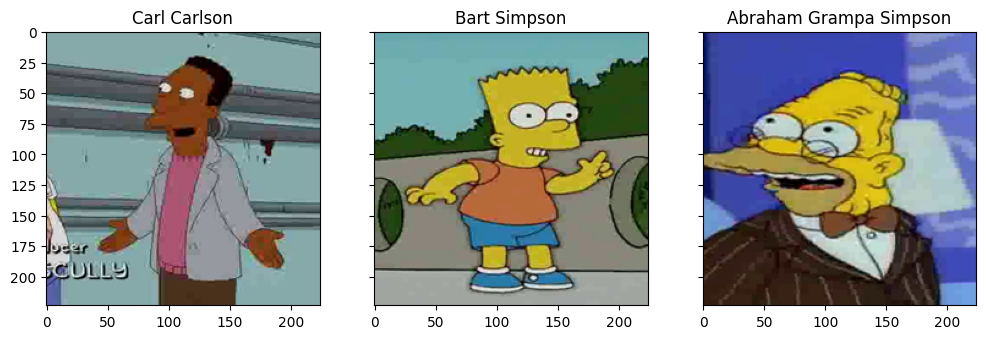

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12, 20), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),title=img_label,plt_ax=fig_x)

## Подготовка модели

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
''' Функция обучения модели была чуть усовершенствована, во первых
увеличин lr=0.001, добавлен scheduler (снизили скорость обучения) '''
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()
            
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Посчитаем колличество классов.

In [15]:
n_classes = len(set(train_val_labels))
print("Кол-во классов: {}".format(n_classes))

Кол-во классов: 42


## AlexNet c заморозкой всего

Иницилиаризируем сеть

In [16]:
AlexNet = models.alexnet(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 287MB/s]


In [17]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
AlexNet.classifier = nn.Linear(num_features, n_classes)

In [18]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = AlexNet.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(AlexNet)

we will classify :42
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)


Запустим обучение сети

In [19]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
history = train(train_dataset, val_dataset, model=AlexNet, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.342417313799113


epoch:  10%|█         | 1/10 [03:52<34:56, 232.99s/it]


Epoch 001 train_loss: 2.3424     val_loss 1.3575 train_acc 0.3568 val_acc 0.6368
loss 0.995857249054835


epoch:  20%|██        | 2/10 [06:19<24:17, 182.24s/it]


Epoch 002 train_loss: 0.9959     val_loss 0.8296 train_acc 0.7313 val_acc 0.7851
loss 0.6136183993771879


epoch:  30%|███       | 3/10 [08:47<19:24, 166.38s/it]


Epoch 003 train_loss: 0.6136     val_loss 0.7462 train_acc 0.8312 val_acc 0.8032
loss 0.36333047892228915


epoch:  40%|████      | 4/10 [11:14<15:54, 159.01s/it]


Epoch 004 train_loss: 0.3633     val_loss 0.6423 train_acc 0.8987 val_acc 0.8389
loss 0.12172379008929694


epoch:  50%|█████     | 5/10 [13:49<13:07, 157.49s/it]


Epoch 005 train_loss: 0.1217     val_loss 0.5241 train_acc 0.9672 val_acc 0.8796
loss 0.060458008261626825


epoch:  60%|██████    | 6/10 [16:17<10:16, 154.21s/it]


Epoch 006 train_loss: 0.0605     val_loss 0.5310 train_acc 0.9862 val_acc 0.8833
loss 0.03647595717410256


epoch:  70%|███████   | 7/10 [18:39<07:30, 150.16s/it]


Epoch 007 train_loss: 0.0365     val_loss 0.5560 train_acc 0.9929 val_acc 0.8842
loss 0.02138431584882535


epoch:  80%|████████  | 8/10 [21:05<04:57, 148.74s/it]


Epoch 008 train_loss: 0.0214     val_loss 0.5779 train_acc 0.9966 val_acc 0.8863
loss 0.012479525088470876


epoch:  90%|█████████ | 9/10 [23:24<02:25, 145.94s/it]


Epoch 009 train_loss: 0.0125     val_loss 0.5814 train_acc 0.9989 val_acc 0.8865
loss 0.01142961035599275


epoch: 100%|██████████| 10/10 [25:42<00:00, 154.21s/it]


Epoch 010 train_loss: 0.0114     val_loss 0.5876 train_acc 0.9990 val_acc 0.8878


Построим графики

In [21]:
loss, acc, val_loss, val_acc = zip(*history)

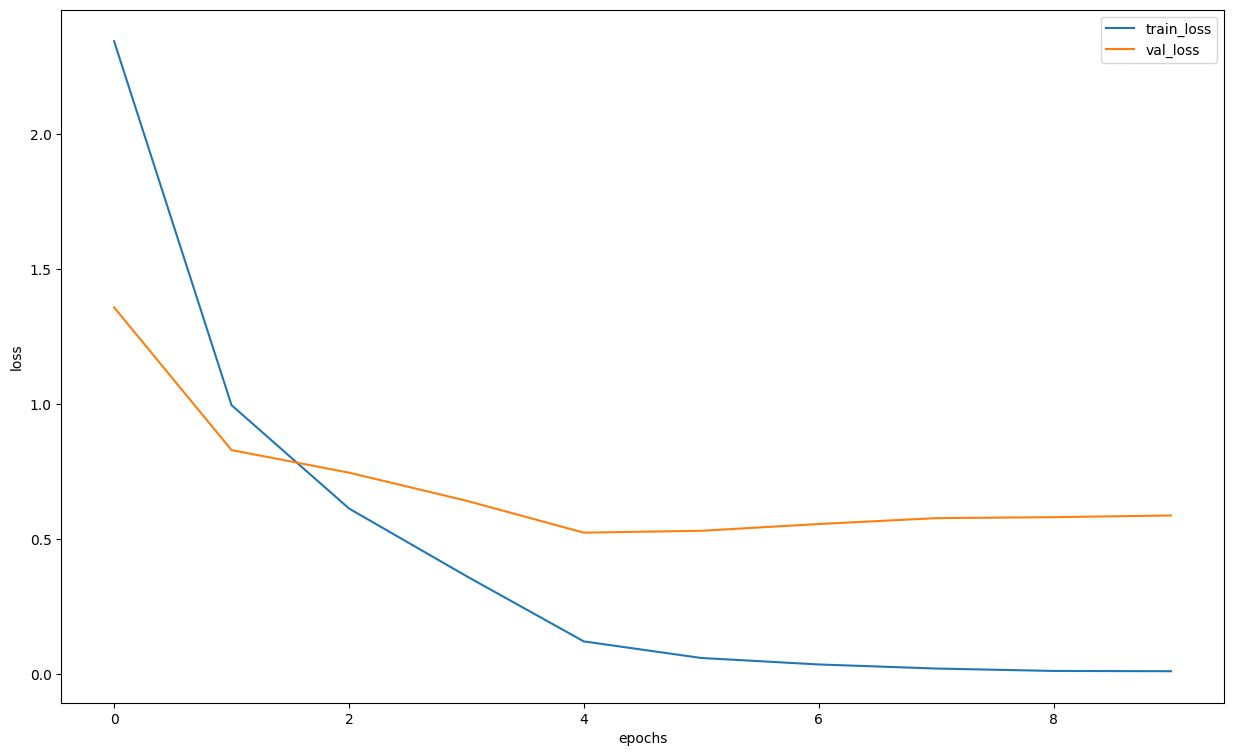

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Предсказание

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [24]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [25]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [26]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [27]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [28]:
from sklearn.metrics import f1_score
print(f1_score(actual_labels, y_pred, average='micro'))

0.9500000000000001


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

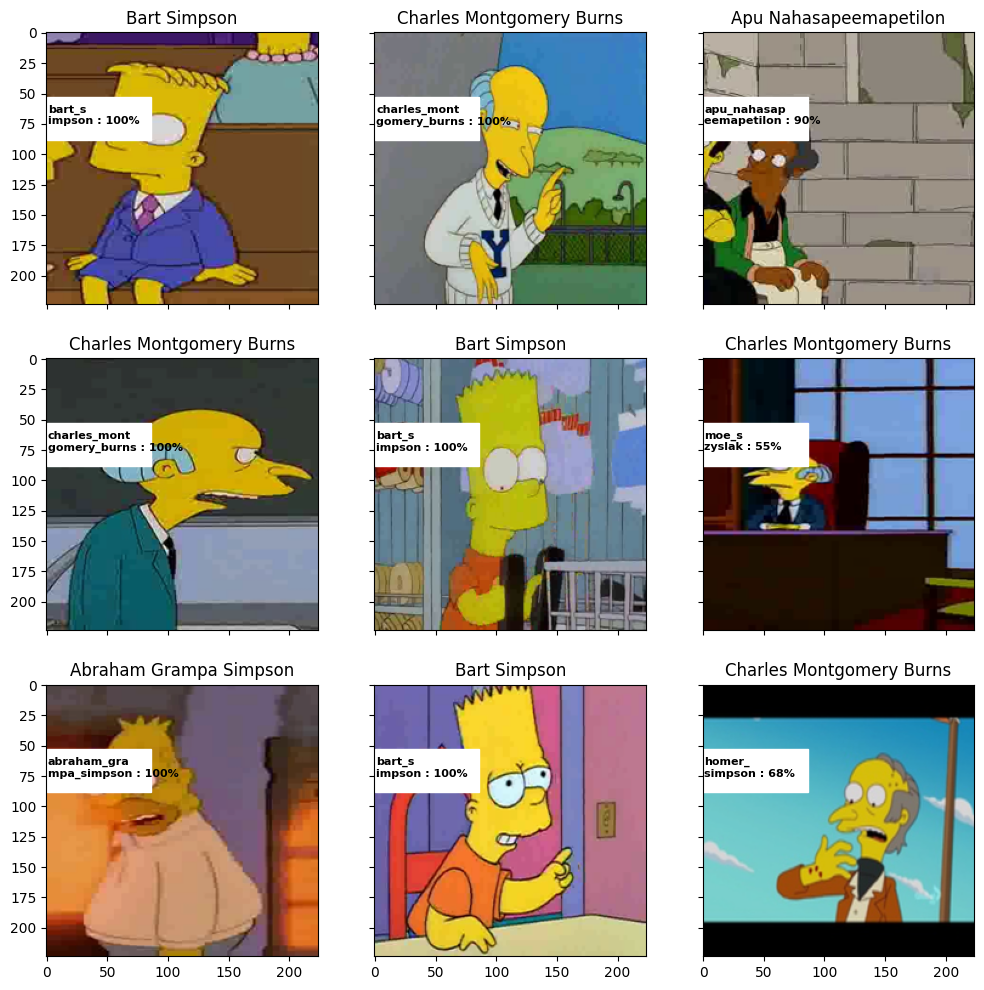

In [29]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## ResNet50 c заморозкой всего

In [30]:
ResNet = torchvision.models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.2MB/s]


Посмотрим на модель 

In [31]:
ResNet.fc

Linear(in_features=2048, out_features=1000, bias=True)

Поменяем последний слой

In [32]:
ResNet.fc = nn.Linear(2048, n_classes)

перекиним модель на GPU

In [33]:
ResNet = ResNet.to(DEVICE)

In [34]:
history = train(train_dataset, val_dataset, model=ResNet, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6128116752533512


epoch:  10%|█         | 1/10 [03:30<31:32, 210.32s/it]


Epoch 001 train_loss: 0.6128     val_loss 0.3452 train_acc 0.8560 val_acc 0.9142
loss 0.15331617160313174


epoch:  20%|██        | 2/10 [07:00<28:00, 210.08s/it]


Epoch 002 train_loss: 0.1533     val_loss 0.3135 train_acc 0.9596 val_acc 0.9167
loss 0.08870706800780742


epoch:  30%|███       | 3/10 [10:30<24:31, 210.23s/it]


Epoch 003 train_loss: 0.0887     val_loss 0.3937 train_acc 0.9762 val_acc 0.9001
loss 0.06711559101850928


epoch:  40%|████      | 4/10 [14:01<21:02, 210.38s/it]


Epoch 004 train_loss: 0.0671     val_loss 0.2929 train_acc 0.9819 val_acc 0.9266
loss 0.02382640690285352


epoch:  50%|█████     | 5/10 [17:30<17:30, 210.01s/it]


Epoch 005 train_loss: 0.0238     val_loss 0.1126 train_acc 0.9936 val_acc 0.9750
loss 0.005197575950040391


epoch:  60%|██████    | 6/10 [21:00<13:59, 209.92s/it]


Epoch 006 train_loss: 0.0052     val_loss 0.1094 train_acc 0.9992 val_acc 0.9773
loss 0.00340970865921177


epoch:  70%|███████   | 7/10 [24:28<10:28, 209.43s/it]


Epoch 007 train_loss: 0.0034     val_loss 0.1083 train_acc 0.9995 val_acc 0.9775
loss 0.0025040821503738444


epoch:  80%|████████  | 8/10 [27:57<06:58, 209.17s/it]


Epoch 008 train_loss: 0.0025     val_loss 0.1069 train_acc 0.9996 val_acc 0.9776
loss 0.0017009202774073478


epoch:  90%|█████████ | 9/10 [31:25<03:28, 208.77s/it]


Epoch 009 train_loss: 0.0017     val_loss 0.1070 train_acc 0.9997 val_acc 0.9784
loss 0.0016881145747617305


epoch: 100%|██████████| 10/10 [34:54<00:00, 209.41s/it]


Epoch 010 train_loss: 0.0017     val_loss 0.1075 train_acc 0.9997 val_acc 0.9778


Построим графики

In [35]:
loss, acc, val_loss, val_acc = zip(*history)

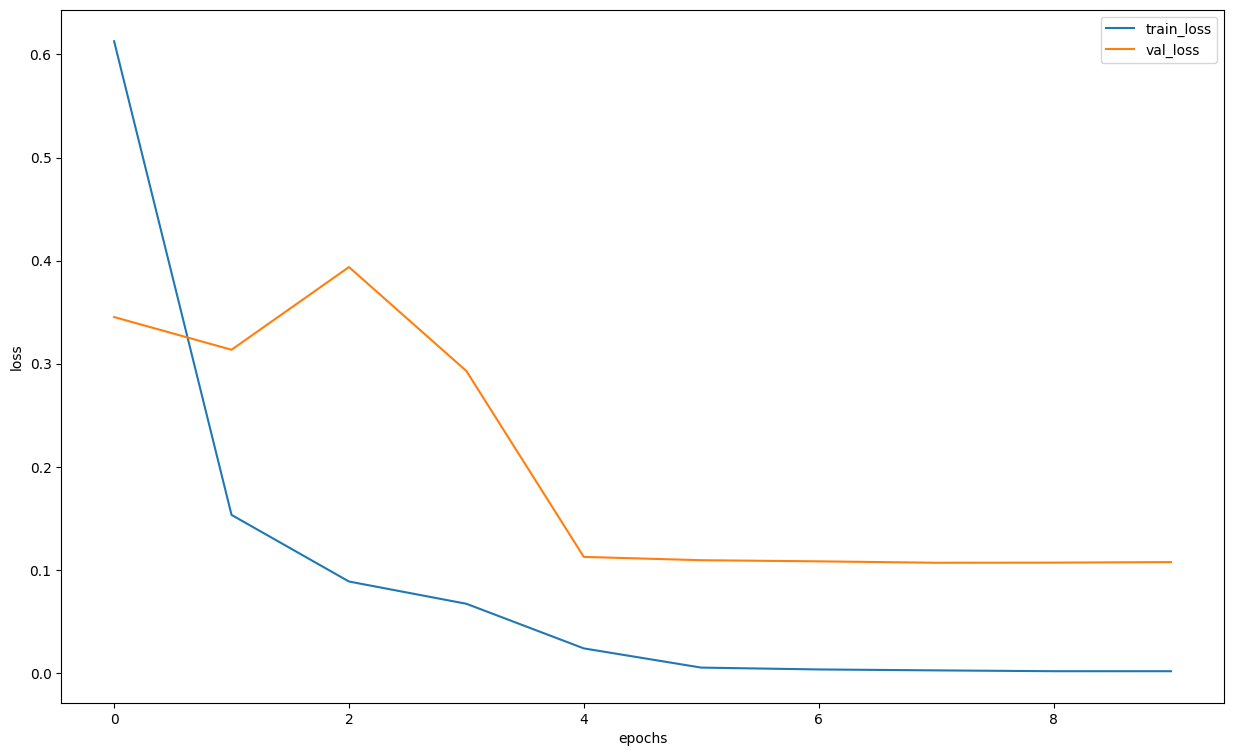

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Предсказание модели

In [37]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(ResNet, ex_img.unsqueeze(0))

In [38]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(ResNet, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
from sklearn.metrics import f1_score
print(f1_score(actual_labels, y_pred, average='micro'))

1.0


Посмотрим на визуализацию

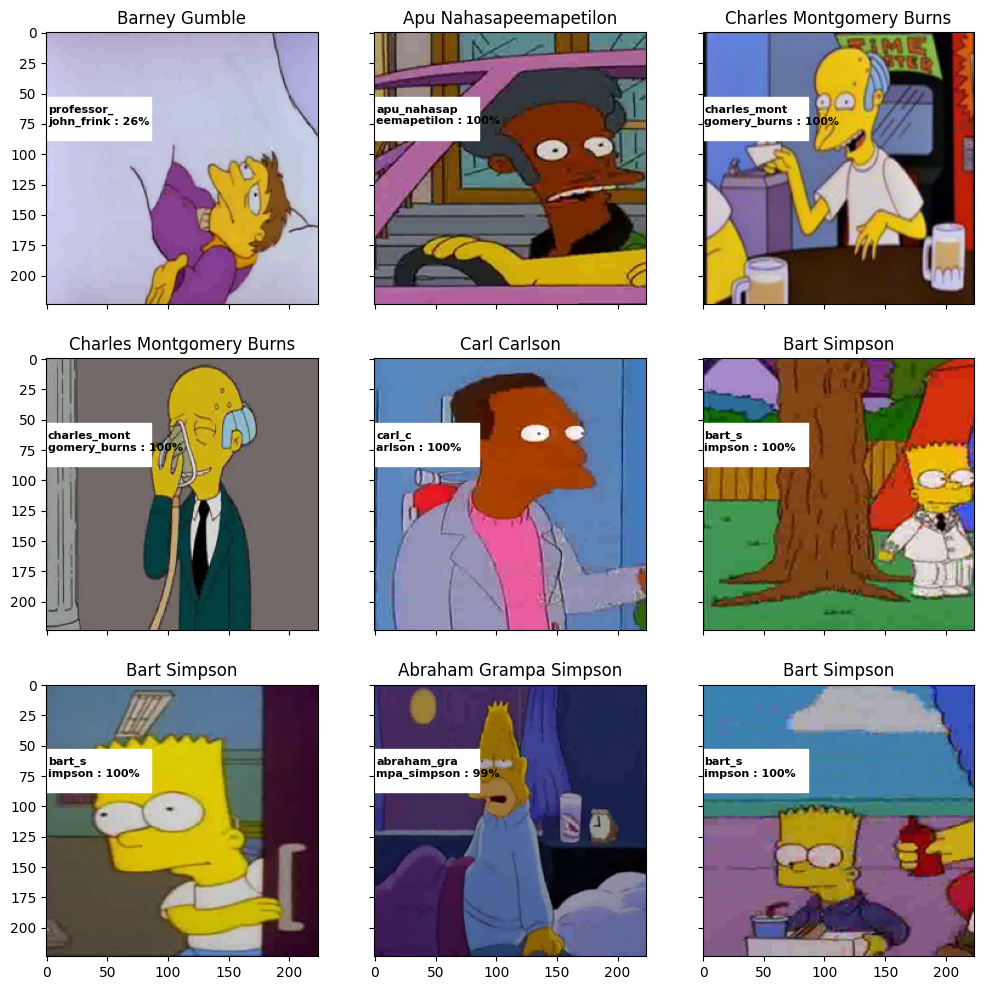

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(ResNet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(ResNet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [44]:
! ls 

__notebook__.ipynb  label_encoder.pkl


In [45]:
import pandas as pd
submit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames

In [46]:
submit[f'Expected'] = preds
submit.to_csv('/kaggle/working/submission.csv', index=False)